UAE PERMAMANENT MISSION NEWS ARTICLE SCRAPER

https://uaeun.org/?combined-search-post-types=press_release&s=

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pandas as pd

STEP 1 - SCRAPE THE URLS AND NEWS ARTICLE CONTENTS SINCE 2022

In [22]:
# --- Config ---
base_url = "https://uaeun.org/"
params = {
    "combined-search-post-types": "press_release",
    "s": "",
    "paged": 1
}
cutoff_date = datetime(2022, 1, 1)

In [23]:
def extract_links_and_dates(html):
    soup = BeautifulSoup(html, "html.parser")
    articles = []
    stop_scraping = False

    for item in soup.select("div.single-item"):
        time_tag = item.find("time")
        link_tag = item.select_one("a[href^='https://uaeun.org/press_release/']")
        title_tag = item.find("strong", class_="title")

        if not time_tag or not link_tag or not title_tag:
            continue
        try:
            date = datetime.strptime(time_tag.text.strip(), "%b %d %Y")
            if date < cutoff_date:
                stop_scraping = True
                break
            title = title_tag.get_text(strip=True)
            url = link_tag['href']
            articles.append((title, url, date))
        except Exception:
            continue
    return articles, stop_scraping

def extract_article_text(url):
    try:
        headers = {
            "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                           "AppleWebKit/537.36 (KHTML, like Gecko) "
                           "Chrome/114.0.0.0 Safari/537.36")
        }
        res = requests.get(url, headers=headers)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "html.parser")

        containers = soup.find_all("div", class_="container")
        for container in containers:
            paragraphs = container.find_all("p")
            if paragraphs:
                return "\n\n".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))

        print(f"⚠️ No paragraph content found at {url}")
        return ""

    except Exception as e:
        print(f"⚠️ Error scraping {url}: {e}")
        return ""

In [24]:
# --- Scraping Loop ---
data = []
page = 1

while True:
    print(f"📄 Fetching page {page}")
    params["paged"] = page
    resp = requests.get(base_url, params=params)
    if resp.status_code != 200:
        print(f"❌ Failed to fetch page {page}")
        break

    entries, stop = extract_links_and_dates(resp.text)
    if not entries:
        print("ℹ️ No more articles found.")
        break

    for title, url, date in entries:
        print(f"🔗 Scraping: {title} ({date.strftime('%Y-%m-%d')})")
        content = extract_article_text(url)
        data.append({
            "title": title,
            "url": url,
            "date": date.strftime("%Y-%m-%d"),
            "content": content
        })
        time.sleep(0.5)

    if stop:
        print("🛑 Reached article older than cutoff date. Stopping.")
        break

    page += 1

# --- Save to DataFrame ---
df = pd.DataFrame(data)
print("\n✅ Scraped DataFrame preview:")
print(df.head())

# --- Save to Excel ---
excel_path = "uae_mission_articles.xlsx"
sheet_name = 'raw'

df.to_excel(excel_path, sheet_name=sheet_name, index=False)
print(f"📄 Articles saved to {excel_path}")

📄 Fetching page 1
🔗 Scraping: The United Nations General Assembly adopts Resolution on the modalities for the 2026 UN Water Conference which will be co-hosted by UAE and Senegal (2024-09-06)
🔗 Scraping: UAE Statement at the UNICEF Special Focus Session on the Impact of Climate Change on Children (2024-09-05)
🔗 Scraping: Ambassador Mohamed Abushahab Appointed Permanent Representative of the UAE to the UN, Presents Credentials to UN Secretary-General António Guterres (2024-04-15)
🔗 Scraping: UAE Statement at the UN General Assembly Meeting on Measures to Eliminate International Terrorism (2023-10-03)
🔗 Scraping: UAE Statement at the UN Security Council Meeting on Chemical weapons in the Syrian Arab Republic (2023-09-07)
🔗 Scraping: UAE Calls on International Community to Implement Balanced Approach to Artificial Intelligence (2023-07-18)
🔗 Scraping: UN Security Council adopts historic UAE- and UK-led resolution on tolerance in addressing hate speech and extremism (2023-06-14)
🔗 Scraping:

STEP 2 - DATA ANALYSIS

In [3]:
excel_path = "uae_mission_articles.xlsx"
sheet_name = 'raw'

df = pd.read_excel(excel_path, sheet_name=sheet_name)

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import _stop_words
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import re

# Custom stopwords
custom_stopwords = set([
    'project', 'include', 'support', 'activities', 'expected', 'providing', 'humanitarian', 'assistance',
    'contributing', 'including', 'increased', 'cfli', 'outcomes', 'projects', 'needs', 'improved',
    'populations', 'people', 'organizations', 'countries', 'affected', 'small', 'international', 'local',
    'human', 'services', 'vulnerable', 'dignity', 'canada', 'aims', 'development', 'persons', 'access',
    'global', 'economic', 'national', 'canadian', 'implementation', 'states', 'capacity', 'acute',
    'outcome', 'million', 'developing', 'action', 'fund', 'united', 'nations', 'funding', '19', 'womenâ',
    'regional', 'priorities', 'red', 'initiatives', 'direct', 'advance', 'strengthen', 'situations',
    'community', 'communities', 'coordination', 'inclusive', 'policy', 'based', 'technical', 'lives',
    'strengthened', 'themes', 'offer', 'focusing', 'provide', 'closely', 'implemented', 'saved', 'ultimate',
    'suffering', 'alleviated', 'maintained', 'experiencing', 'excellency', 'meeting', 'met', 'qna', 'efforts',
    'new', 'york', 'qatar', 'qatars', 'challenges', 'event', 'role', 'highlighted', 'althani', 'alya',
    'ahmed', 'bin', 'cooperation', 'state', 'sheikha', 'saif', 'discussed', 'doha', 'general', 'headquarters',
    'permanent', 'mission', 'republic', 'affairs', 'representative', 'president', 'east', 'world', 'assembly',
    'noted', 'added', 'said', 'thani', 'secretary', 'under', 'joint', 'sides', 'minister', 'expresses', 'al',
    'foreign', 'ministry', 'reiterates', 'importance', 'condolences', 'bilateral', 'dialogue', 'ministers',
    'targeting', 'strategic', 'warns', 'welcomed', 'strongly', 'expressed', 'agreed', 'firm', 'position', 'region',
    'strong', 'welcomes', 'qatari', 'parties','aimed', 'solution', 'reaffirms', 'twostate', 'prime', 'held', 'field',
    'commitment', 'relations', 'speedy', 'visit', 'january', 'uaes', 'members', 'process', 'nusseibeh', 'security',
    'council', 'march', 'june', 'situation', 'thank', 'important', 'ambassador', 'need', 'presidential', 'ensure',
    'arab', 'emirates', 'league', 'address', 'promote', 'promoting', 'continue', 'called', 'work', 'statement',
    'government', 'use', 'resolution', 'uae'
])

texts = df['content'].dropna().tolist()

# Combine the default English stopwords with custom list:
english_stopwords = _stop_words.ENGLISH_STOP_WORDS  # set of default english stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords))

vectorizer = CountVectorizer(
    max_df=0.85, 
    min_df=5, 
    stop_words=all_stopwords
)

In [46]:
# Topic Identification without bigrams
dtm = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out(),3)

Topic 0:
['law', 'climate', 'peace']
Topic 1:
['women', 'peace', 'terrorism']
Topic 2:
['mr', 'violence', 'sustainable']
Topic 3:
['houthis', 'terrorist', 'attacks']
Topic 4:
['women', 'peace', 'conflict']


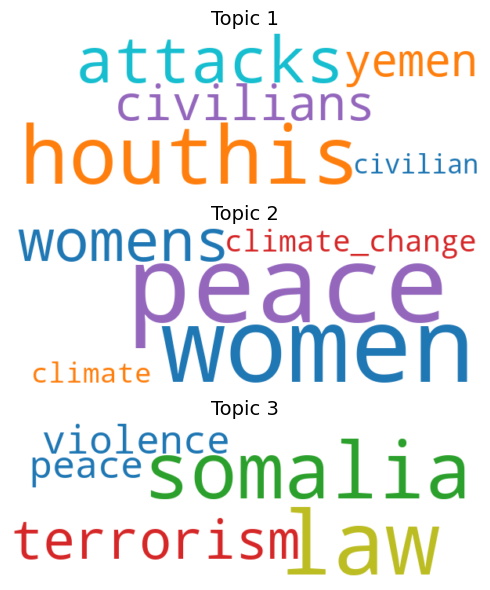

In [47]:
# Topic identification with bigrams
# Text preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in all_stopwords and len(token) > 2]
    return tokens

# Tokenize texts
tokenized_texts = [preprocess(doc) for doc in texts]

# Build bigrams
bigram_model = Phrases(tokenized_texts, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_model)
texts_with_bigrams = [bigram_phraser[doc] for doc in tokenized_texts]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts_with_bigrams)
dictionary.filter_extremes(no_below=5, no_above=0.75)
corpus = [dictionary.doc2bow(text) for text in texts_with_bigrams]

# Train LDA model with 3 topics
num_topics = 3
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Define figure size in inches for a roughly square layout
fig_width = 6
fig_height = 6

# Each word cloud will have height = fig_height / num_topics
wc_width = int(fig_width * 100)   # 100 dpi
wc_height = int((fig_height / num_topics) * 100)

plt.figure(figsize=(fig_width, fig_height))

for topic_id in range(num_topics):
    plt.subplot(num_topics, 1, topic_id + 1)
    words_probs = dict(lda_model.show_topic(topic_id, topn=5))
    wc = WordCloud(
        width=wc_width,
        height=wc_height,
        background_color='white',
        colormap='tab10',
        prefer_horizontal=0.9,
        min_font_size=15,
    ).generate_from_frequencies(words_probs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id + 1}", fontsize=14)

plt.tight_layout()
plt.show()

In [48]:
# Export Topics Words and Weights to Excel for PowerBI
topic_words = []
num_words = 5  # Adjust based on your needs

for topic_id in range(num_topics):
    words_probs = lda_model.show_topic(topic_id, topn=num_words)
    for word, prob in words_probs:
        topic_words.append({"Topic": topic_id + 1, "Word": word, "Probability": prob})

# Convert to DataFrame
wc = pd.DataFrame(topic_words)

sheet_name = "Topic_WordCloud"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    wc.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to Topic_WordCloud in uae_mission_articles.xlsx


Identifying Themes Via Keyword Frequency

In [49]:
X = vectorizer.fit_transform(texts)

# Convert to readable DataFrame
X_array = X.toarray()
vocab = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_array, columns=vocab)

# View output
print("Bag of Words Matrix:\n", bow_df.head())

Bag of Words Matrix:
    10  14  15  17  2021  2022  2023  accordance  accountable  achieve  ...  \
0   0   0   0   0     0     0     0           0            0        0  ...   
1   0   0   0   0     0     0     0           0            1        0  ...   
2   0   0   0   0     1     1     1           0            0        0  ...   
3   0   0   1   0     0     0     0           2            0        1  ...   
4   0   0   0   0     0     0     0           0            0        1  ...   

   voice  way  welcome  women  working  year  years  yemen  youth  zayed  
0      0    0        0      0        0     0      0      0      0      1  
1      0    0        0      0        1     1      0      0      3      0  
2      0    0        0      1        1     0      0      0      0      3  
3      0    1        0      1        0     1      0      0      1      0  
4      0    0        0      0        0     0      0      0      0      0  

[5 rows x 247 columns]


In [50]:
# Sum each word's count across all rows
word_counts = bow_df.sum(axis=0)

# Sort words by frequency (descending)
top_words = word_counts.sort_values(ascending=False)

print("Top words:")
print(top_words.head(20))

Top words:
women        105
peace        104
climate       66
terrorist     53
law           51
terrorism     37
2022          37
attacks       37
change        36
conflict      35
today         30
somalia       30
houthis       29
relevant      24
lana          23
acts          23
political     22
month         22
civilian      21
time          20
dtype: int64


In [51]:
# Determine the most important words using TF-IDF
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# To get overall importance of each word across the corpus, sum TF-IDF scores across all documents
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

print("Top Themes by TF-IDF:")
print(word_importance.head(10))

Top Themes by TF-IDF:
women        2.866709
peace        2.510322
climate      2.300757
terrorist    1.933179
houthis      1.772467
law          1.689561
attacks      1.610521
change       1.306885
conflict     1.223326
terrorism    1.165585
dtype: float64


AI Tagging

In [2]:
excel_path = "uae_mission_articles.xlsx"

In [3]:
tagged = pd.read_excel(excel_path, sheet_name="raw")

tagged.head()

,title,url,date,content,theme_1,theme_2
0,The United Nations General Assembly adopts Res...,https://uaeun.org/press_release/unga-wc-resolu...,2024-09-06,The United Arab Emirates has welcomed today’s ...,Water and Sanitation,Conflict Resolution
1,UAE Statement at the UNICEF Special Focus Sess...,https://uaeun.org/press_release/uae-statement-...,2024-09-05,"Delivered by: HE Mohamed Abushahab, Ambassador...",Climate Change,Youth Empowerment
2,Ambassador Mohamed Abushahab Appointed Permane...,https://uaeun.org/press_release/uae-pressrelea...,2024-04-15,"On Monday, Ambassador Mohamed Abushahab, the n...",UN and Multilateral Diplomacy,UN and Multilateral Diplomacy
3,UAE Statement at the UN General Assembly Meeti...,https://uaeun.org/press_release/unga-6c-ct-3oct/,2023-10-03,"Delivered by Tahreer Al Marzooqi, Third Secret...",Counter-Terrorism,Human Rights
4,UAE Statement at the UN Security Council Meeti...,https://uaeun.org/press_release/uae-unsc-syria...,2023-09-07,"Delivered By Mr. Rashed Azzam, Attaché\n\nUNOF...",Weapon Proliferation,Counter-Terrorism


In [4]:
tagged = tagged.melt(
    id_vars = [col for col in tagged.columns if col not in ['theme_1', 'theme_2']],
    value_vars = ['theme_1', 'theme_2'],
    var_name = 'theme_source',
    value_name = 'theme'
)

tagged = tagged.drop(columns=['theme_source'])

tagged['date'] = pd.to_datetime(tagged['date'], errors='coerce')
tagged['year'] = tagged['date'].dt.year

tagged.head()

,title,url,date,content,theme,year
0,The United Nations General Assembly adopts Res...,https://uaeun.org/press_release/unga-wc-resolu...,2024-09-06,The United Arab Emirates has welcomed today’s ...,Water and Sanitation,2024
1,UAE Statement at the UNICEF Special Focus Sess...,https://uaeun.org/press_release/uae-statement-...,2024-09-05,"Delivered by: HE Mohamed Abushahab, Ambassador...",Climate Change,2024
2,Ambassador Mohamed Abushahab Appointed Permane...,https://uaeun.org/press_release/uae-pressrelea...,2024-04-15,"On Monday, Ambassador Mohamed Abushahab, the n...",UN and Multilateral Diplomacy,2024
3,UAE Statement at the UN General Assembly Meeti...,https://uaeun.org/press_release/unga-6c-ct-3oct/,2023-10-03,"Delivered by Tahreer Al Marzooqi, Third Secret...",Counter-Terrorism,2023
4,UAE Statement at the UN Security Council Meeti...,https://uaeun.org/press_release/uae-unsc-syria...,2023-09-07,"Delivered By Mr. Rashed Azzam, Attaché\n\nUNOF...",Weapon Proliferation,2023


In [5]:
sheet_name = "tagging"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    tagged.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to tagging in uae_mission_articles.xlsx
